# Restricted Boltzmann Machines

The explanations in this notebook are taken from: 
- [Deep Learning meets Physics: Restricted Boltzmann Machines Part I (Towards Data Science)](https://towardsdatascience.com/deep-learning-meets-physics-restricted-boltzmann-machines-part-i-6df5c4918c15)

- [Deep Learning meets Physics: Restricted Boltzmann Machines Part II (Towards Data Science)](https://towardsdatascience.com/deep-learning-meets-physics-restricted-boltzmann-machines-part-ii-4b159dce1ffb)

- [Restricted Boltzman machine (Wikipedia)](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)

## Architecture of a RBM
<center><img src="https://cdn-images-1.medium.com/max/1600/1*HkaD1isPyQ2ijl9lxXkV3A.png" width=700 class="center"></center>

One purpose of deep learning models is to encode dependencies between variables. The capturing of dependencies happen through associating of a scalar energy to each configuration of the variables, which serves as a measure of compatibility. A high energy means a bad compatibility. An energy based model model tries always to minimize a predefined energy function. The energy function for the RBMs is defined as (**Eq. 1**):

<center><img src="https://cdn-images-1.medium.com/max/1600/1*dJggFW3OL9Y420gWeJXMBw.png" width=400 class="center"></center>

At each point in time the RBM is in a certain state. The state refers to the values of neurons in the visible and hidden layers $\mathbf{v}$ and $\mathbf{h}$. The probability that a certain state of $\mathbf{v}$ and $\mathbf{h}$ can be observed is given by the following joint distribution (**Eq. 2**):

<center><img src="https://cdn-images-1.medium.com/max/1600/1*Iq2Tn7aLAegiIg4sfkSgGA.png" width=200 class="center"></center>

Here $\mathbf{Z}$ is called the ‘partition function’ that is the summation over all possible pairs of visible and hidden vectors.

Unfortunately it is very difficult to calculate the joint probability due to the huge number of possible combination of $\mathbf{v}$ and $\mathbf{h}$ in the partition function $\mathbf{Z}$. Much easier is the calculation of the conditional probabilities of state $\mathbf{h}$ given the state $\mathbf{v}$ and conditional probabilities of state $\mathbf{v}$ given the state $\mathbf{h}$ (**Eq. 3**):

<center><img src="https://cdn-images-1.medium.com/max/1600/1*NxzVmlmv6KDqO2k77WnfnA.png" width=200 class="center"></center>

It should be noticed that each neuron in a RBM can only exist in a binary state of 0 or 1. Given an input vector $\mathbf{v}$ the probability for a single hidden neuron $j$ being activated is (**Eq. 4**):

<center><img src="https://cdn-images-1.medium.com/max/1600/1*yx_C_ItC8aCUYbHhCJQY5g.png" width=450 class="center"></center>

Here $\sigma$ is the Sigmoid function. This equation is derived by applying the Bayes Rule to Eq. 3.

Analogous the probability that a binary state of a visible neuron $i$ is set to 1 is (**Eq. 5**):

<center><img src="https://cdn-images-1.medium.com/max/1600/1*6BMmNqK8H3a_BFSq5K3j-A.png" width=450 class="center"></center>

## Training of a RBM
Restricted Boltzmann machines are trained to maximize the product of probabilities assigned to some training set $\mathbf{V}$ (a matrix, each row of which is treated as a visible vector $\mathbf{v}$),

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a" width=150 class="center"></center>

or equivalently, to maximize the expected log probability of a training sample $\mathbf{v}$ selected randomly from $\mathbf{V}$:

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/15d7e252690209a35d218dfaa0502782bccf0cac" width=200 class="center"></center>

The algorithm most often used to train RBMs, that is, to optimize the weight vector $\mathbf{W}$ is the contrastive divergence (CD). The algorithm performs Gibbs sampling and is used inside a gradient descent procedure to compute weight update.

The basic, single-step contrastive divergence (CD-1) procedure for a single sample can be summarized as follows:

1. Take a training sample $v$, compute the probabilities of the hidden units and sample a hidden activation vector $h$ from this probability distribution.
2. Compute the outer product of $v$ and $h$ and call this the *positive gradient*.
3. From $h$, sample a reconstruction $v'$ of the visible units, then resample the hidden activations $h'$ from this. (Gibbs sampling step)
4. Compute the outer product of $v'$ and $h'$ and call this the *negative gradient*.
5. Let the update to the weight matrix $\mathbf{W}$ be the positive gradient minus the negative gradient, times some learning rate: 
<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/4af2af0b8f0522006fef96b3d8a79b007decbf44" width=200 class="center"></center>
6. Update the biases $a$ and $b$ analogously:
<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/841914c5dd339996ac500e060c847b40bdb7941f" width=150 class="center"></center>

To sum up, the update to the weight matrix is:

$$
    \Delta w_{ij} = \epsilon\left( <v_ih_j>_{data} - <v_ih_j>_{reconstruction} \right)
$$



In [129]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [130]:
n_samples = 100
n_features = 10
n_classes = 3
test_size = 0.3

data, y = make_classification(n_samples=n_samples, 
                           n_features=n_features,
                           n_classes=n_classes,
                           n_redundant=0, 
                           n_repeated=0, 
                           n_clusters_per_class=1)

# binarizing X
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = np.where(data > 0.5, 0, 1)

In [131]:
num_hidden = 10
num_visible = n_features

max_epochs = 10000
learning_rate = 0.1

In [132]:
# initialize a weight matrix of dimensions (num_visible x num_hidden)
np_rng = np.random.RandomState(42)

weights = np_rng.uniform(low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)), 
                         high=0.1 * np.sqrt(6. / (num_hidden + num_visible)), 
                         size=(num_visible, num_hidden))

# adding bias weights
weights = np.vstack((np.zeros((1, weights.shape[1])), weights))
weights = np.hstack((np.zeros((weights.shape[0], 1)), weights))

In [133]:
# training

# insert bias units of 1 into the first column
data = np.hstack((np.ones((data.shape[0], 1)), data))

100%|██████████| 10000/10000 [00:00<00:00, 11389.20it/s]


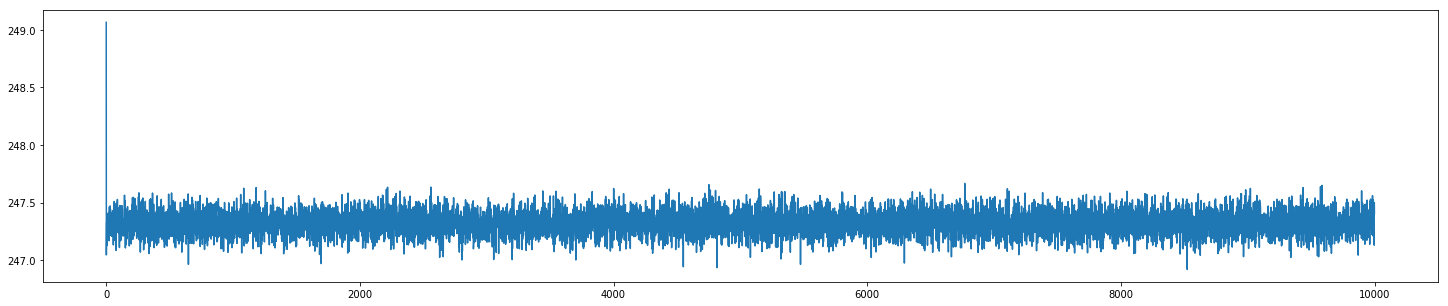

In [134]:
def logistic(x):
    return 1.0 / (1 + np.exp(-x))

errors = []

for epoch in tqdm(range(max_epochs)):    
    # X: (num_samples x num_features)
    # W: (num_features x num_hidden)
    
    # Positive gradient phase
    pos_hidden_activations = np.dot(data, weights)                                          # H = XW   (num_samples x num_hidden)
    pos_hidden_probs = logistic(pos_hidden_activations)                                     # H = logistic(XW) (num_samples x num_hidden)
    pos_hidden_probs[:,0] = 1                                                               # Fix the bias unit. (num_samples x num_hidden)
    pos_hidden_states = pos_hidden_probs > np.random.rand(data.shape[0], num_hidden + 1)    # HS = binarize(H)
    
    # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
    # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
    # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
    pos_associations = np.dot(data.T, pos_hidden_probs)                                     # A = (X^T)H   (n_features x num_hidden)
    
    # Negative gradient phase
    neg_visible_activations = np.dot(pos_hidden_states, weights.T)                          # R = H(W^T) (num_samples x num_features)
    neg_visible_probs = logistic(neg_visible_activations)                                   # R = logistic(H(W^T)) (num_samples x num_features)
    neg_visible_probs[:,0] = 1                                                              # Fix the bias unit. (num_samples x num_features)
    neg_hidden_activations = np.dot(neg_visible_probs, weights)                             # H' = RW (num_samples x num_hidden)
    neg_hidden_probs = logistic(neg_hidden_activations)                                     # H' = logistic(RW) (num_samples x num_hidden)
    # Note, again, that we're using the activation *probabilities* when computing associations, not the states themselves.
    neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)                        # A' = (R^T)H'  (n_features x num_hidden)
    
    
    # Update weights
    weights = learning_rate * ((pos_associations - neg_associations) / data.shape[0])       # W' = lr*(A - A') / num_samples
    
    # error computation
    error = np.sum((data - neg_visible_probs)**2)
    errors.append(error)
    
plt.figure(figsize=(25, 5))
plt.plot(errors)
plt.show()